# Metronome Evaluation

Code for preprint Section 3 / Figure 1.

In [2]:
import metronome as met
import numpy as np
import pandas as pd

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import (
    cross_val_score,
    StratifiedShuffleSplit,
)

import Bio.Align

In [3]:
%load_ext rpy2.ipython

In [4]:
from importlib.metadata import version

version("metronome")

'0.1.1'

## Set up Metronome Scorers

In [4]:
# Match dict - bonus for matches, penalty for mismatches
md = {
    ("|", "|"): 3.5,
    ("w", "w"): 2.5,
    ("S", "S"): 3,
    (".", "."): 1,
    # penalise non-alignment at line ends more, because they're rarer. The idea
    # is to stop hendecasyllables being routinely padded out to match hexameter
    # lines
    ("|", "S"): -4,
    ("|", "w"): -4,
    ("|", "."): -4,
    ("w", "S"): -0.25,
    ("w", "."): 0,  # not sure. In theory we don't care if spaces mismatch
    ("S", "."): 0,  # because metre isn't based on a fixed number of words
}
# open and extend penalties for alignment gaps
open_penalty = -6
extend_penalty = -3

scorer = met.scoring.Scorer(
    match_dict=md, open_gap_score=open_penalty, extend_gap_score=extend_penalty
)

In [5]:
naive_scorer = met.scoring.Scorer()
naive_scorer.aligner = Bio.Align.PairwiseAligner()
naive_scorer_plus = met.scoring.Scorer()
naive_scorer_plus.aligner = Bio.Align.PairwiseAligner(
    open_gap_score=-1, extend_gap_score=-0.1
)

## Import Datasets

In [6]:
cldf = pd.read_csv("../data/crosslang_subset.csv", index_col=0, sep="\t")
cldf["metronome"] = cldf.metronome.str.replace("0", "w")
cldf["metronome"] = cldf.metronome.str.replace("1", "S")
cldf

,work,born,year,metronome,meter,lang
author,,,,,,
"Puškin, Aleksander Sergeevič",XXXVIII,NaN,1818.0,w.Sw.Sw.SwSw.|w.S.w.ww.S.wS.|w.w.Sw.wSw.Sw.|w....,I4,de
"Herder, Johann Gottfried",47.,NaN,1773.0,w.Sw.Sw.S.wS..|wSw.Sw.Sw.S.|w.S.w.Sw.S.|w.S.wS...,T5,de
"Holz, Arno",Er bekröhnt ihn mit einem Hirsch-Geweih,NaN,1883.0,wSw.w.w.S.|wS.w.w.w.S.|w.Sw.Sw.SwS...|w.Sw.SwS...,T5,de
"Ḥāfeẓ, Šams o'd-din Moḥammad",73.,NaN,1357.0,w.w.w.Sw.w.wS.|w.Sw.S.ww.w.Sw.|wS.wS.w.w.w.S.w...,I4,de
"Fontane, Theodor",1.,NaN,1856.0,w.Sw.Sw.Sw.Sw..|w.Sw.Sw.w.wS..|w.SwSw.S.wS.w.|...,I4,de
...,...,...,...,...,...,...
"Calma, Marie",V parku.,1881.0,1921.0,w.Sw.Sww.w.Sw.Sw.Sw.|S.w.w.Sw.Sww.w.S.w.|w.Sww...,I5,cs
"Calma, Marie",Za radostí.,1881.0,1921.0,S.S.www.Sw.S.www.|w.Sw.Sw.S.w.Sw.w.|w.Sw.Sw.S....,I5,cs
"Calma, Marie",To's nebyl ty!,1881.0,1921.0,w.Sw.S.w.Sw.S.w.Sw.|w.Sww.w.Sw.Sw.Sw.|w.Sw.w.w...,I5,cs


In [7]:
# Three languages, six meters. The snallest category (ru I4_3) has 179 poems, so
# it's safe to take a balanced sample of that many poems from each category
cldf.groupby("lang").meter.value_counts()

lang  meter
cs    I5       17314
      T4        9317
      I4        6525
      I4_3      5869
      T5        3036
      T4_3      2355
de    I4        4225
      T4        4222
      I5        4016
      T5        1760
      I4_3       536
      T4_3       413
ru    I4        4415
      T4        1957
      I5        1264
      T5         275
      T4_3       262
      I4_3       179
Name: count, dtype: int64

In [8]:
ltdf = pd.read_csv("../data/classical_latin.csv", keep_default_na=False)
ltdf = ltdf.rename(columns={"metre": "meter"})
ltdf

,canonical_title,author,work,meter,book,number,title,lines,metronome
0,Satires 12,Juvenal,Satires,hexameter,,12,,130,SSS.SSw.wS.ww.Sww.S.S.|S.SS.SSw.wS.wwSww.SS.|S...
1,Eclogues 3,Vergil,Eclogues,hexameter,3,,,111,S.ww.SSS.SS.ww.S.wwSS.|S.S.SSS.SS.ww.Sww.SS.|S...
2,Argonautica 5,Valerius Flaccus,Argonautica,hexameter,5,,,695,Sww.S.S.Sw.wS.SSw.wSS.|SwwS.SS.SSw.wSww.SS.|Sw...
3,Satires 8,Juvenal,Satires,hexameter,,8,,275,Sww.S.wwS.S.SS.Sww.SS.|Sww.SSS.SS.SSww.SS.|SS....
4,Fasti 3,Ovid,Fasti,elegy,3,,,884,Sww.SwwS.wwS.SSw.w.SS.|S.ww.S.wwS.Sww.Sw.wS.|S...
...,...,...,...,...,...,...,...,...,...
2583,Silvae 5.4,Statius,Silvae,hexameter,5,4,Somnvs,19,Sww.S.wwS.wwS.wwSww.SS.|S.SSw.wS.SS.S.Sw.wSS.|...
2584,Silvae 5.5,Statius,Silvae,hexameter,5,5,Epicedion In Pvervm Svvm,87,S.wwS.w.wS.SS.SSww.SS.|SwwS.S.SwwS.SSww.SS.|SS...
2585,Punica 16,Silius Italicus,Punica,hexameter,16,,,700,Sww.SSS.SS.wwSw.wSS.|Sww.SSS.SS.S.Sww.SS.|S.SS...
2586,De Rerum Natura 3,Lucretius,De Rerum Natura,hexameter,3,,,1095,S.wwS.SS.S.S.SSww.SS.|S.SS.wwS.SSS.Sww.SS.|S.w...


In [9]:
lt_common_df = ltdf[
    ltdf.meter.isin(ltdf.meter.value_counts().nlargest(6).index)
].reset_index(drop=True)
lt_common_df.meter.value_counts()

meter
elegy               1663
hendecasyllables     321
hexameter            219
senarii              140
scazon                92
alcaic                38
Name: count, dtype: int64

## Run Evaluations

### Fully configured Metronome scorer

In [10]:
knn = KNeighborsClassifier(n_neighbors=7, metric="precomputed", n_jobs=-1)
knn_res = []
ari_res = []
rng = np.random.default_rng(seed=42)
for _ in range(50):
    # balanced sample over 24 combinations of meter+language
    s1 = (
        cldf.groupby(["lang", "meter"])
        .sample(10, random_state=rng)
        .reset_index(drop=True)
    )
    s2 = (
        lt_common_df.groupby(["meter"])
        .sample(10, random_state=rng)
        .reset_index(drop=True)
    )
    s = pd.concat([s1, s2]).reset_index(drop=True)
    dm = scorer.dist_matrix_parallel(s)
    knn.fit(dm, s.meter)
    knn_res.append(knn.score(dm, s.meter))

2024-04-22 15:27:29,561	INFO worker.py:1749 -- Started a local Ray instance.


In [12]:
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 144

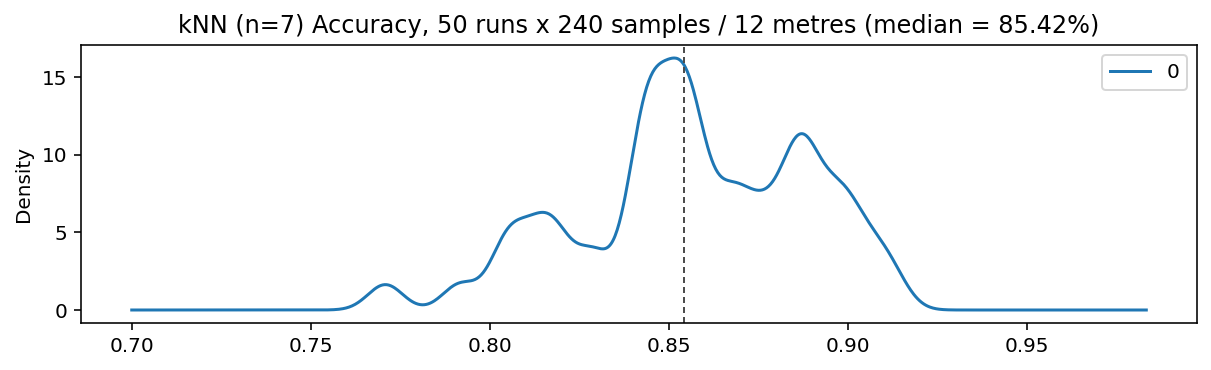

In [13]:
ax = pd.DataFrame(knn_res).plot(
    kind="kde",
    bw_method=0.15,
    figsize=(10, 2.5),
    title=f"kNN (n=7) Accuracy, 50 runs x 240 samples / 12 metres (median = {np.median(knn_res):.2%})",
)
ax.axvline(np.median(knn_res), color=".3", dashes=(3, 2), linewidth=1)

### Naive Scorer

In [14]:
knn = KNeighborsClassifier(n_neighbors=7, metric="precomputed", n_jobs=-1)
knn_default_res = []
ari_default_res = []
rng = np.random.default_rng(seed=42)
for _ in range(50):
    # balanced sample over 18 combinations of meter+language
    s1 = (
        cldf.groupby(["lang", "meter"])
        .sample(10, random_state=rng)
        .reset_index(drop=True)
    )
    s2 = (
        lt_common_df.groupby(["meter"])
        .sample(10, random_state=rng)
        .reset_index(drop=True)
    )
    s = pd.concat([s1, s2]).reset_index(drop=True)
    dm = naive_scorer.dist_matrix_parallel(s)
    knn.fit(dm, s.meter)
    knn_default_res.append(knn.score(dm, s.meter))

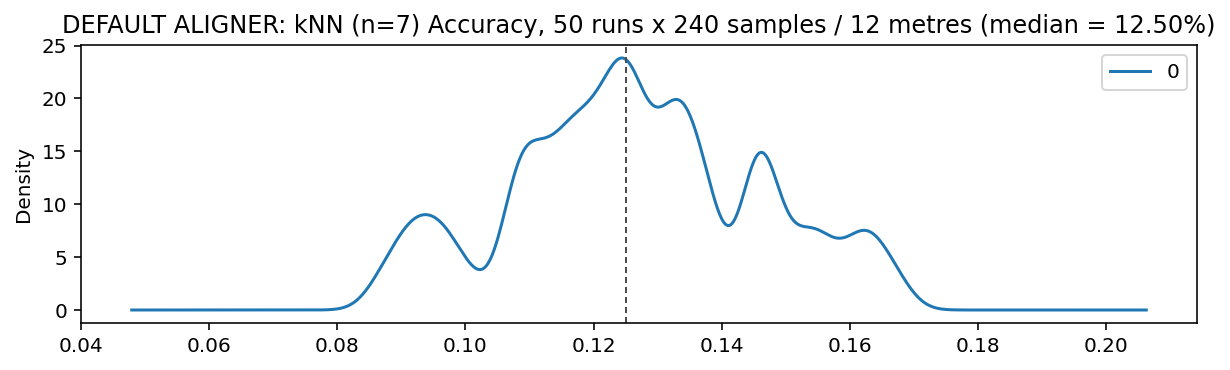

In [17]:
ax = pd.DataFrame(knn_default_res).plot(
    kind="kde",
    bw_method=0.15,
    figsize=(10, 2.5),
    title=f"DEFAULT ALIGNER: kNN (n=7) Accuracy, 50 runs x 240 samples / 12 metres (median = {np.median(knn_default_res):.2%})",
)
ax.axvline(np.median(knn_default_res), color=".3", dashes=(3, 2), linewidth=1)

### Naive scorer with insert / delete

In [18]:
knn = KNeighborsClassifier(n_neighbors=7, metric="precomputed", n_jobs=-1)
knn_default_plus_res = []
ari_default_plus_res = []
rng = np.random.default_rng(seed=42)
for _ in range(50):
    # balanced sample over 18 combinations of meter+language
    s1 = (
        cldf.groupby(["lang", "meter"])
        .sample(10, random_state=rng)
        .reset_index(drop=True)
    )
    s2 = (
        lt_common_df.groupby(["meter"])
        .sample(10, random_state=rng)
        .reset_index(drop=True)
    )
    s = pd.concat([s1, s2]).reset_index(drop=True)
    dm = naive_scorer_plus.dist_matrix_parallel(s)
    knn.fit(dm, s.meter)
    knn_default_plus_res.append(knn.score(dm, s.meter))

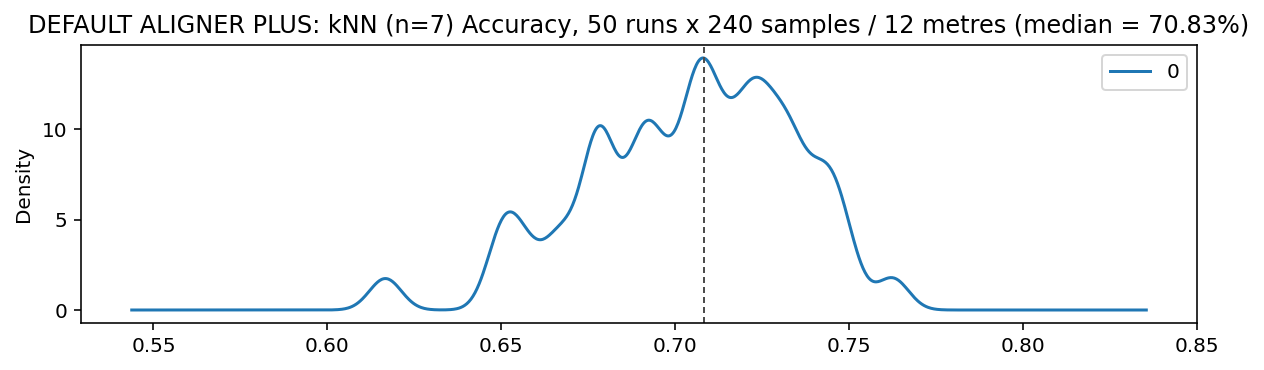

In [19]:
ax = pd.DataFrame(knn_default_plus_res).plot(
    kind="kde",
    bw_method=0.15,
    figsize=(10, 2.5),
    title=f"DEFAULT ALIGNER PLUS: kNN (n=7) Accuracy, 50 runs x 240 samples / 12 metres (median = {np.median(knn_default_plus_res):.2%})",
)
ax.axvline(np.median(knn_default_plus_res), color=".3", dashes=(3, 2), linewidth=1)

### SVM Classifier

In [20]:
vectorizer2 = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True,
        use_idf=False,
        norm="l2",
        analyzer="char",
        ngram_range=(9, 9),
        max_features=500,
    ),
    TruncatedSVD(n_components=50),
    StandardScaler(),
    Normalizer(),
)

In [42]:
rng = np.random.RandomState(seed=42)
svm_res = []
for _ in range(50):
    # balanced sample over 18 combinations of meter+language
    s1 = (
        cldf.groupby(["lang", "meter"])
        .sample(13, random_state=rng)
        .reset_index(drop=True)
    )
    s2 = (
        lt_common_df.groupby(["meter"])
        .sample(13, random_state=rng)
        .reset_index(drop=True)
    )
    s = pd.concat([s1, s2]).reset_index(drop=True)
    clf = LinearSVC(dual="auto")
    X = vectorizer2.fit_transform(s.metronome)
    # roughly 80/20 test/train, but have 10 items in the train set to match the other evaluations (otherwise SVM would
    # be disadvantaged)
    cv = StratifiedShuffleSplit(n_splits=10, test_size=3 / 13, random_state=rng)
    svm_res.extend(cross_val_score(clf, X, s.meter, cv=cv, scoring="accuracy"))

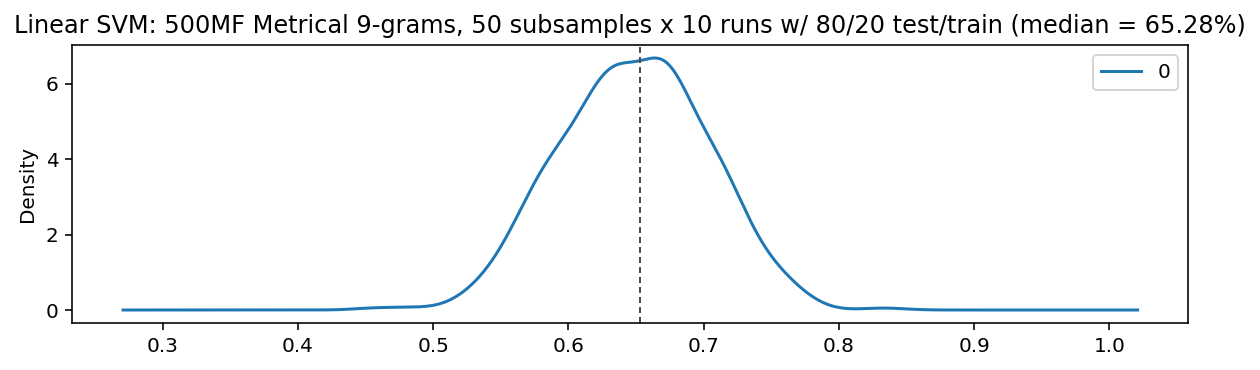

In [43]:
ax = pd.DataFrame(svm_res).plot(
    kind="kde",
    # bw_method=0.22,
    figsize=(10, 2.5),
    title=f"Linear SVM: 500MF Metrical 9-grams, 50 subsamples x 10 runs w/ 80/20 test/train (median = {np.median(svm_res):.2%})",
)
ax.axvline(np.median(svm_res), color=".3", dashes=(3, 2), linewidth=1)

## Format and visualise results

In [44]:
eval_df = pd.DataFrame(
    {
        "Metronome": knn_res,
        "Naïve": knn_default_res,
        "Naïve + Gaps": knn_default_plus_res,
    }
)
eval_df = pd.concat([eval_df, pd.DataFrame({"SVM (500 MF 9-grams)": svm_res})])

In [47]:
# df = eval_df.melt(var_name="method", value_name="value").dropna()
# df["ours"] = df.apply(lambda x: (x["method"] == "Metronome"), axis=1)
# df.to_csv("eval_results_preprint.csv")
# df

,method,value,ours
0,Metronome,0.791667,True
1,Metronome,0.845833,True
2,Metronome,0.887500,True
3,Metronome,0.804167,True
4,Metronome,0.854167,True
...,...,...,...
2195,SVM (500 MF 9-grams),0.638889,False
2196,SVM (500 MF 9-grams),0.736111,False
2197,SVM (500 MF 9-grams),0.597222,False
2198,SVM (500 MF 9-grams),0.652778,False


In [4]:
df = pd.read_csv("eval_results_preprint.csv", index_col=0)
df

,method,value,ours
0,Metronome,0.791667,True
1,Metronome,0.845833,True
2,Metronome,0.887500,True
3,Metronome,0.804167,True
4,Metronome,0.854167,True
...,...,...,...
2195,SVM (500 MF 9-grams),0.638889,False
2196,SVM (500 MF 9-grams),0.736111,False
2197,SVM (500 MF 9-grams),0.597222,False
2198,SVM (500 MF 9-grams),0.652778,False


Picking joint bandwidth of 0.0115


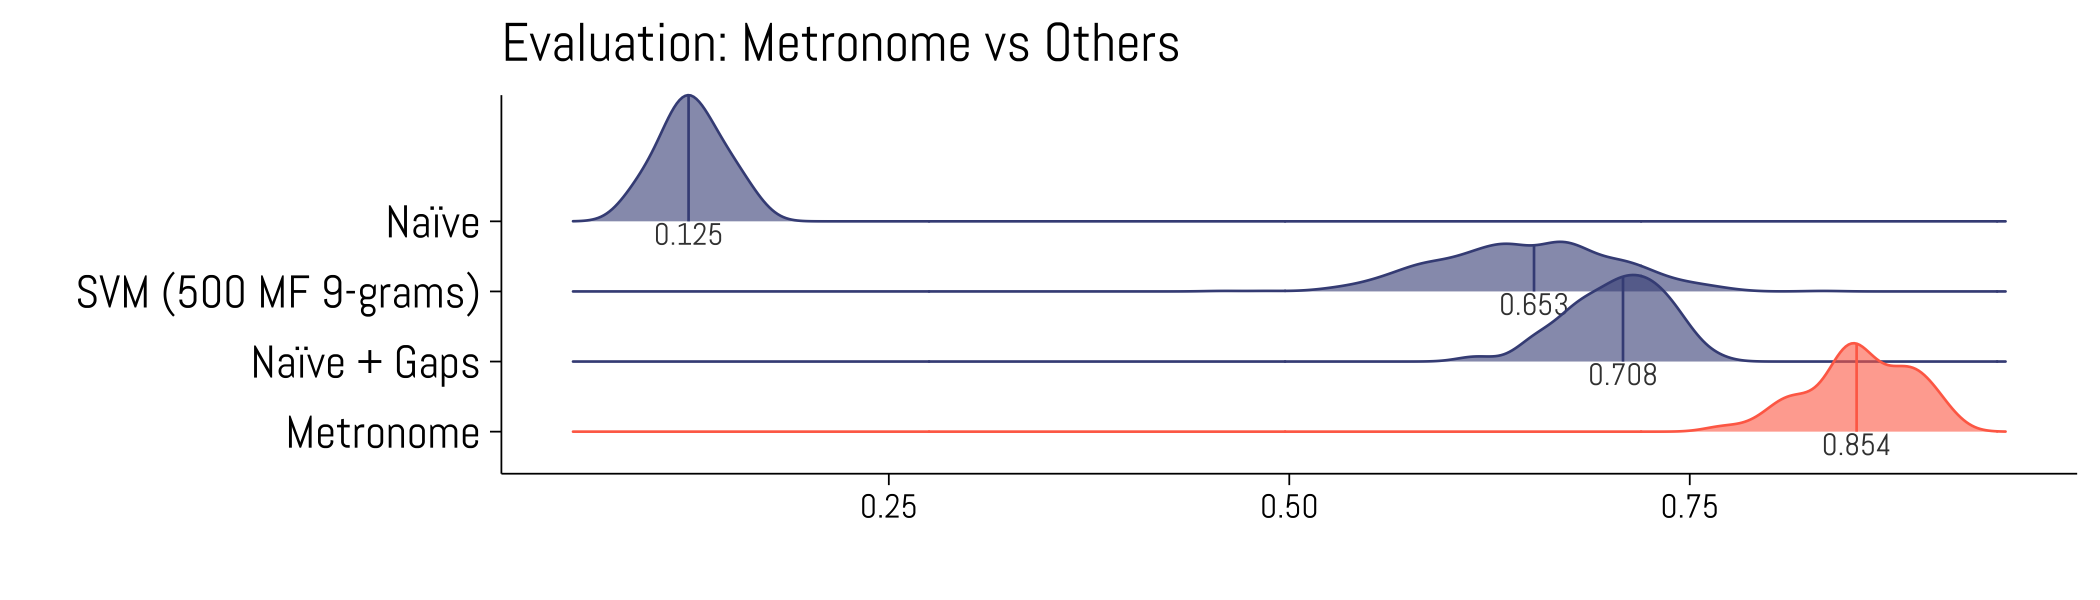

In [6]:
%%R -i df -h 2 -w 7 -u in -r 300
library(ggridges)
library(paletteer)
library(ggplot2)
library(showtext)
library(forcats)
font_add_google("Abel", "fnt")
showtext_auto()

plt <- c(
    '#444e86',
    '#ff6e54'
)
bgcol <- 'white'
fgcol <- 'black'


p <- ggplot(data=df,aes(value,y=fct_rev(fct_reorder(method, value, median)),fill=ours,color=ours)) +
stat_summary(fun = "median", colour = "grey25", size = 2.6,
                 geom = "text", aes(family="fnt", label = round(after_stat(x),3)),
                 position = position_nudge(y = -0.18)) +
coord_cartesian(clip = "off") +
ggridges::stat_density_ridges(
    alpha = .6, quantile_lines=T, quantiles=2, linewidth=0.3
) +
scale_colour_manual(values=plt) +
scale_fill_manual(values=plt) +
theme_bw() +
xlab("") +
ylab("") +
ggtitle("Evaluation: Metronome vs Others") +
theme(
    panel.border = element_blank(),
    legend.position='none',
    panel.background = element_rect(fill = bgcol,color=bgcol),
    plot.background = element_rect(fill = bgcol,color=bgcol),
    plot.title = element_text( size=13, family="fnt", color=fgcol),
    axis.line.x=element_line(linewidth=0.2,color=fgcol),
    axis.line.y=element_line(linewidth=0.2,color=fgcol),
    axis.ticks.x=element_line(linewidth=0.2,color=fgcol),
    axis.ticks.y=element_line(linewidth=0.2,color=fgcol),
    axis.text.x=element_text(size=8, family="fnt", color=fgcol),
    axis.text.y=element_text(size=11, family="fnt", color=fgcol),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
)

# fn <- "../paper/figures/evaluation.pdf"
# ggsave(fn, dpi=600, width=7, height=2, device=cairo_pdf)

p


In [7]:
%%R

sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Sonoma 14.4.1

Matrix products: default
BLAS:   /System/Library/Frameworks/Accelerate.framework/Versions/A/Frameworks/vecLib.framework/Versions/A/libBLAS.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] C/UTF-8/C/C/C/C

time zone: Europe/Warsaw
tzcode source: internal

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] forcats_1.0.0   showtext_0.9-7  showtextdb_3.0  sysfonts_0.8.9 
[5] ggplot2_3.5.0   paletteer_1.6.0 ggridges_0.5.6 

loaded via a namespace (and not attached):
 [1] vctrs_0.6.5      cli_3.6.2        rlang_1.1.3      rematch2_2.1.2  
 [5] generics_0.1.3   jsonlite_1.8.8   labeling_0.4.3   glue_1.7.0      
 [9] colorspace_2.1-0 scales_1.3.0     fansi_1.0.6      grid_4.3.3      
[13] munsell_0.5.0    tibble_3.2